In [9]:
pip install pyspark==3.0.0

Note: you may need to restart the kernel to use updated packages.


In [20]:
from pyspark.sql import SparkSession

working_directory = 'jars/*'

spark = SparkSession.\
        builder.\
        appName("pyspark-with-mongo-1").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1g").\
        config("spark.mongodb.input.uri","mongodb://mongodb:27017/datascience.movies").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        config('spark.driver.extraClassPath', working_directory). \
        getOrCreate()

sc = spark.sparkContext

In [25]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri", "mongodb://mongodb:27017/datascience.movies")\
    .load()

## Który aktor wystąpił najwięcej razy

In [26]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- actors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- awards: struct (nullable = true)
 |    |-- nominations: double (nullable = true)
 |    |-- oscars: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- bestAnimatedFeature: string (nullable = true)
 |    |    |    |-- bestMusic: string (nullable = true)
 |    |    |    |-- bestPicture: string (nullable = true)
 |    |    |    |-- bestScreenplay: string (nullable = true)
 |    |    |    |-- bestSoundEditing: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- wins: double (nullable = true)
 |-- countries: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- director: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- imdb: struct (nullable = true)
 |    |-- id: strin

In [27]:
from pyspark.sql.functions import *

In [28]:
Most_popular_actors = df.select(
        '_id',
        explode_outer('actors').alias('actor')
    )\
    .where(column('actor').isNotNull())\
    .groupBy('actor')\
    .agg(
        count("actor").alias('movies_count')
    )\
    .orderBy(desc('movies_count'))\
    .limit(10)

In [29]:
Most_popular_actors.cache()

DataFrame[actor: string, movies_count: bigint]

In [30]:
Most_popular_actors.show()

+------------------+------------+
|             actor|movies_count|
+------------------+------------+
|   Natalie Portman|           8|
|        Louis C.K.|           8|
|         Tom Hanks|           8|
|Scarlett Johansson|           7|
|     Ewan McGregor|           7|
|         B.B. King|           7|
|    Shah Rukh Khan|           7|
|       Ben Stiller|           6|
|     Brian Johnson|           6|
| Patricia Arquette|           6|
+------------------+------------+



In [31]:
X = Most_popular_actors.toPandas()

<AxesSubplot:xlabel='actor'>

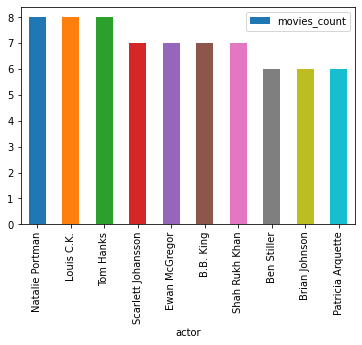

In [32]:
X.plot.bar(x="actor", y="movies_count")

In [33]:
(df.write.format("orc")
    .save("movies.orc"))

AnalysisException: path file:/opt/workspace/80--spark/movies.orc already exists.;

In [ ]:
loadedDf = spark.read.format("orc").load("movies.orc")

In [ ]:
loadedDf.show()

In [ ]:
sc.stop()